In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()

In [2]:
from auxillary_functions import *
from polynomial_featextract import poly_featextract

In [3]:
datadir_path = "E:\\gsoc-2021\\work\\data\\2021-06-21_classify_datagen_all_funcs"

In [4]:
rawdata = load_data(datadir_path)
params = load_params(datadir_path)
ker_integrals = load_wlist(datadir_path) # load wlist.txt file

# Stencil type : {'0' : 'Gaussian', '1' : 'Power Law', '2' : 'RKKY'}

Finished loading rawdata into numpy array
Finsihed loading parameters file
finished loading kernel-integrals file.


In [255]:
rawdata_norm = rawdata[:,:-1] / np.max(rawdata[:,:-1],axis=1,keepdims=True)

In [266]:
print(rawdata.shape)
offset = 150
shifted_data, center = get_window(rawdata,2/3,width=offset)
print("The Echo pulse occurs at timestep:",center)

# Rescaled data
rscl_data = shifted_data / np.max(shifted_data,axis=1,keepdims=True)

(10500, 943)
The Echo pulse occurs at timestep: 628


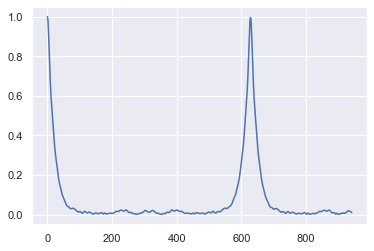

In [257]:
plt.plot(rawdata_norm[0,:])

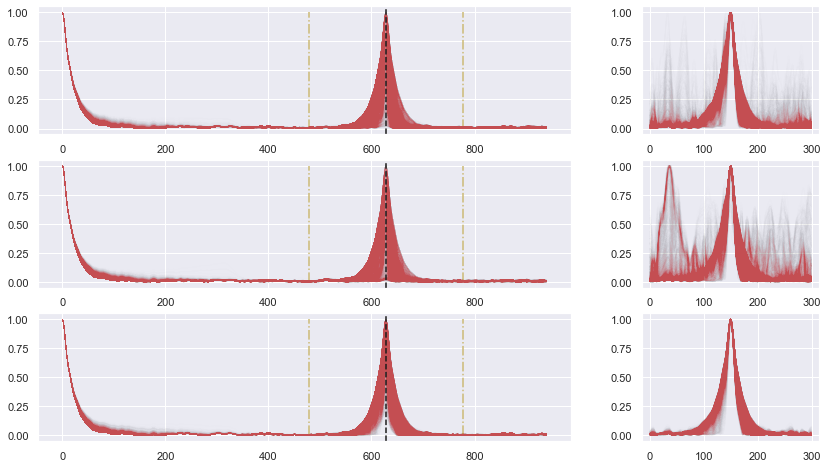

In [272]:
fig, axes = plt.subplots(3,2,gridspec_kw={'width_ratios': [3, 1]}, figsize=(14,8))

for idx in range(3):
    for full_ts, capped_ts in zip(rawdata_norm[params["stencil_type"] == idx,:-1], rscl_data[params["stencil_type"] == idx,:]):
        axes[idx,0].plot(full_ts,'r',alpha=0.002)
        axes[idx,1].plot(capped_ts,'r',alpha=0.002)
    axes[idx,0].axvline(x=628,color='k',ls='--', label='Echo Pulse')    
    axes[idx,0].vlines(x=[628-150, 628+150], ymin=0,ymax=1, color='y', ls='-.', label='Area of Interest')

plt.show()

In [273]:
yo = rawdata_norm[params["stencil_type"] == 2,:-1]

In [ ]:
for i in range(3500):
    plt.plot(yo)

(10500, 943)
The Echo pulse occurs at timestep: 628


In [6]:
y_classes = get_yclasses(params, ker_integrals)

In [7]:
%time polyfeats = poly_featextract(rscl_data, n_splits=[4,5,10], order_fits=[3,3,3], as_df=True)

Wall time: 53.2 s


## Training a RF model

In [106]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone

In [13]:
y_classes.head()

,αx,αz,len_scale
0,0.000140,0.004113,3.471444
1,0.000288,0.005442,2.838588
2,0.000948,0.000869,4.783256
3,0.008380,0.014527,1.950423
4,0.000710,0.013350,1.764475


In [170]:
def get_fi(model, X_data, kind):
    """Get feature importance dataframe from fitted model"""

    if kind == 'timeseries':
        fi = pd.DataFrame(np.array([np.arange(1,len(X_data)).astype(int),
                                    model.feature_importances_*100 ]).T, 
                        columns=['timestamp','fi'])
        fi['fi'] = pd.to_numeric(df['fi'])
        return fi.sort_values('fi', ascending=False)

    if kind == "polyfeatures":
        fi = pd.DataFrame(np.array([X_data.columns.tolist(),
                       model.feature_importances_]).T,
             columns=['feature','fi'])
        fi["fi"] = pd.to_numeric(fi["fi"], downcast="float")
        fi['order'] = fi['feature'].apply(lambda x : x.split("_")[-1])
        fi["color"] = fi["order"].replace({'0':'r','1':'b','2':'g','3':'y'})

        return fi.sort_values('fi', ascending=False)

In [224]:
def features_vs_r2(X: np.ndarray, y: np.ndarray, model, test_size:float, cv:int, stratify):
    """Computes the cv score and best-fit model along with fi importances for the given (X,y). 
    Then the number of features is reduced using feature_imp > median and a new model is trained. 
    Returns a dataframe with full logs"""
    
    to_keep = X.columns.tolist()
    data= []
    for i in range(5):
        print(f"Running iter {i+1}")
        m = clone(model)
        print(f"Number of features: {len(to_keep)}")
        X_train, X_test, y_train, y_test = train_test_split(X[to_keep], y, test_size=test_size,
                                                            random_state=101, stratify=stratify)
        print(f"Computing cross-validation scores")
        scores = cross_val_score(m, X_train, y_train, cv=cv, n_jobs=-1)
        print(f"Cross val-scores: {np.mean(scores)  :.3} +- {np.std(scores) :.3}")
        
        print(f"Done! \n Fitting model")
        m.fit(X_train, y_train)
        
        test_score = m.score(X_test, y_test)
        print(f"Test score: {test_score :.3}")
        
        fi = get_fi(m, X_train, "polyfeatures")
        data.append([len(to_keep), to_keep, m,fi[fi.fi >= fi.fi.median()].fi, scores.mean(), test_score])
        to_keep = fi[fi.fi >= fi.fi.median()].feature
        print()
                     
    return data

In [225]:
m = RandomForestRegressor(n_estimators=40, max_features=0.5, n_jobs=-1)
to_keep = polyfeats.columns.tolist()

In [226]:
df = features_vs_r2(polyfeats, y_classes['αx'], m, 0.2, cv=5, stratify=params['stencil_type'] )

Running iter 1
Number of features: 76
Computing cross-validation scores
Cross val-scores: 0.963 +- 0.00231
Done! 
 Fitting model
Test score: 0.971
Running iter 2
Number of features: 38
Computing cross-validation scores
Cross val-scores: 0.962 +- 0.00148
Done! 
 Fitting model
Test score: 0.971
Running iter 3
Number of features: 19
Computing cross-validation scores
Cross val-scores: 0.953 +- 0.00278
Done! 
 Fitting model
Test score: 0.963
Running iter 4
Number of features: 10
Computing cross-validation scores
Cross val-scores: 0.913 +- 0.00549
Done! 
 Fitting model
Test score: 0.923
Running iter 5
Number of features: 5
Computing cross-validation scores
Cross val-scores: 0.874 +- 0.00647
Done! 
 Fitting model
Test score: 0.881


In [227]:
n_feats = pd.DataFrame([[df[i][0], df[i][-2], df[i][-1]] for i in range(5)], columns=['n_feats','cv_score','test_score'])

In [228]:
df[-1][1]

0     5_1_2
1    10_5_2
2     4_1_2
5     4_4_2
3    10_4_1
Name: feature, dtype: object

In [229]:
n_feats

,n_feats,cv_score,test_score
0,76,0.963094,0.970885
1,38,0.961895,0.970848
2,19,0.953309,0.962954
3,10,0.912638,0.923196
4,5,0.873629,0.880611


In [230]:
xax = np.arange(5)

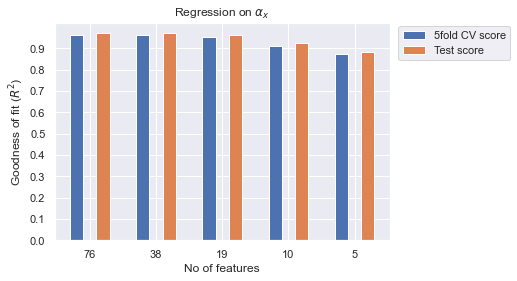

In [238]:
ax = plt.subplot(111)
ax.bar(xax-0.2, n_feats.cv_score, width=0.2, label='5fold CV score')
ax.bar(xax+0.2, n_feats.test_score, width=0.2, label='Test score')
plt.legend(bbox_to_anchor=[1.01,1.01])
plt.xticks(np.arange(5),n_feats.n_feats.values)
plt.yticks(np.arange(0,1,0.1))
ax.set(xlabel="No of features", ylabel="Goodness of fit ($R^2$)", title=r"Regression on $\alpha _x$")

plt.show()

## FEature importance plots

In [ ]:
### Feature importance plot

def fi_df2plot(fi_df: pd.DataFrame, ntop:int, ax):
    """Plots the feature importance plot based on imp_feats data"""

    feats = fi_df.head(ntop)['feature'].values.tolist()
    feats = list(map(lambda x  : x.split('_') , feats))

    ax.set(xlabel="Time")
    for idx, feature in enumerate(feats):
        plot_feature(ax, intervals, feature, idx+1)
    return ax

def plot_feature(axes, intervals:np.ndarray, feature:tuple, plot_index:int):
    """Given an axes object, plots a line-bar for the given feature of the form (10,5,2) where:
        10 : order of partition 
        5 : the bin of interest in the parition
        2 : order of the polynomial in the given bin
        We choose a color for the order of the polynomial (0th, 1st, 2nd, 3rd)
    Returns : an axes object
    """
    color_arr = ['r','b','g','y']

    axes.plot(intervals[int(feature[0])][int(feature[1])-1: int(feature[1])+1],
            [plot_index, plot_index], lw=10,
            color = color_arr[int(feature[2])], label=f"$x^{int(feature[2])}$"
            )
    end_time = [max(intervals[key]) for key in intervals.keys()][0]
    axes.plot([0,end_time],[plot_index+0.5, plot_index+0.5],color=(0,0,0,.2))
    ax.legend()
    
    
class FeaturePlot:
    def __init__(self, ntseries):
        self.ntseries = ntseries

    def get_intervals(self, n_splits:list) -> np.ndarray :
        """Gives the time-interval splits for the number of splits given
        Returns : Dictionary with the n_split as the key and the time-interval stamps as values"""
        split_index = [np.linspace(0, self.ntseries, i+1).astype(np.int32) for i in n_splits]
        intervals = {}
        for idx, interval in zip([4,5,10],split_index):
            intervals[idx] = interval 
        return intervals
    
